In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
interval=60
split_count=10

In [3]:
# Načtení dat
df = pd.read_csv('sorted_test_data.csv', parse_dates=['Datum'])

In [4]:
df.head()

,Datum,Den_v_tydnu,Porucha
0,2023-01-01,6,0
1,2023-01-02,0,0
2,2023-01-03,1,0
3,2023-01-04,2,2
4,2023-01-05,3,0


In [5]:
# Převedení sloupce Datum na timestamp
df['Timestamp'] = df['Datum'].astype('int64')

In [6]:
df.head()

,Datum,Den_v_tydnu,Porucha,Timestamp
0,2023-01-01,6,0,1672531200000000000
1,2023-01-02,0,0,1672617600000000000
2,2023-01-03,1,0,1672704000000000000
3,2023-01-04,2,2,1672790400000000000
4,2023-01-05,3,0,1672876800000000000


In [7]:
# Vybrání relevantních sloupců
data = df[['Den_v_tydnu', 'Porucha','Timestamp']]

In [8]:
# Normalizace dat
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
scaled_data[:10]

array([[1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.001001  ],
       [0.16666667, 0.        , 0.002002  ],
       [0.33333333, 0.66666667, 0.003003  ],
       [0.5       , 0.        , 0.004004  ],
       [0.66666667, 0.        , 0.00500501],
       [0.83333333, 0.        , 0.00600601],
       [1.        , 0.        , 0.00700701],
       [0.        , 0.        , 0.00800801],
       [0.16666667, 0.        , 0.00900901]])

In [10]:
# Příprava trénovacích dat pro předpověď poruch
X, y = [], []
for i in range(len(data)-interval):
    X.append(scaled_data[i:i+interval])
    y.append(1 if any(scaled_data[i+interval:i+interval+7, 1] == 1) else 0)

X, y = np.array(X), np.array(y)

In [11]:
X.shape

(940, 60, 3)

In [12]:
from sklearn.model_selection import TimeSeriesSplit

In [13]:
# Vytvoření instance TimeSeriesSplit s počtem skládek (folds) dle počtu epoch
tscv = TimeSeriesSplit(n_splits=split_count)

In [14]:
# Inicializace prázdných seznamů pro trénovací a testovací data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

In [15]:
# Rozdělení dat pomocí časově řazené křížové validace
for train_index, test_index in tscv.split(X):
    X_train_list.append(X[train_index])
    X_test_list.append(X[test_index])
    y_train_list.append(y[train_index])
    y_test_list.append(y[test_index])

In [16]:
# Definice LSTM modelu pro předpověď poruch
model = Sequential()
model.add(LSTM(units=82, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid pro výstup pravděpodobnosti
model.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 82)            28208     
                                                                 
 lstm_1 (LSTM)               (None, 100)               73200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 101509 (396.52 KB)
Trainable params: 101509 (396.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Připravení seznamu pro ukládání hodnot loss
train_loss_history = []
val_loss_history = []

In [19]:
len(X_train_list)

10

In [20]:
# Trénování modelu na jedné epochě v každém kroku křížové validace
for i in range(len(X_train_list)):
    X_train_fold, y_train_fold = X_train_list[i], y_train_list[i]
    X_test_fold, y_test_fold = X_test_list[i], y_test_list[i]

    # Trénování modelu na jedné epochě
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_test_fold, y_test_fold))

    # Uložení hodnot loss do seznamů
    train_loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

Epoch 1/10
2/2 [==============================] - 4s 929ms/step - loss: 0.7050 - val_loss: 0.7170
Epoch 2/10
2/2 [==============================] - 0s 142ms/step - loss: 0.6959 - val_loss: 0.6805
Epoch 3/10
2/2 [==============================] - 0s 144ms/step - loss: 0.6916 - val_loss: 0.6556
Epoch 4/10
2/2 [==============================] - 0s 140ms/step - loss: 0.6914 - val_loss: 0.6433
Epoch 5/10
2/2 [==============================] - 0s 140ms/step - loss: 0.6911 - val_loss: 0.6435
Epoch 6/10
2/2 [==============================] - 0s 139ms/step - loss: 0.6904 - val_loss: 0.6449
Epoch 7/10
2/2 [==============================] - 0s 139ms/step - loss: 0.6896 - val_loss: 0.6511
Epoch 8/10
2/2 [==============================] - 0s 143ms/step - loss: 0.6882 - val_loss: 0.6622
Epoch 9/10
2/2 [==============================] - 0s 135ms/step - loss: 0.6867 - val_loss: 0.6729
Epoch 10/10
2/2 [==============================] - 0s 140ms/step - loss: 0.6860 - val_loss: 0.6857
Epoch 1/10
3/3 [===

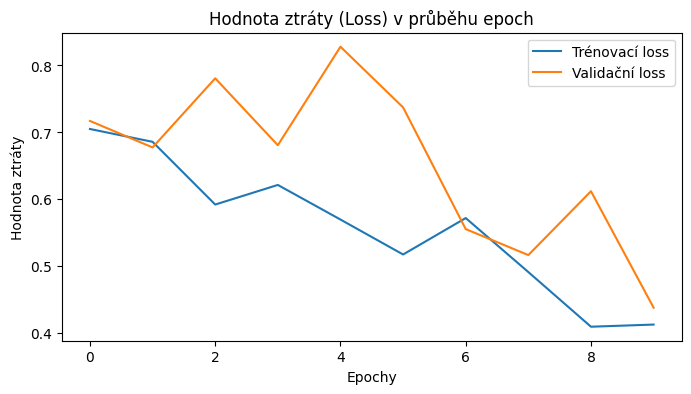

In [21]:
# Vykreslení loss per epoch
plt.figure(figsize=(8, 4))
plt.plot(train_loss_history, label='Trénovací loss')
plt.plot(val_loss_history, label='Validační loss')
plt.title('Hodnota ztráty (Loss) v průběhu epoch')
plt.xlabel('Epochy')
plt.ylabel('Hodnota ztráty')
plt.legend()
plt.show()

In [22]:
scaled_data

array([[1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.001001  ],
       [0.16666667, 0.        , 0.002002  ],
       ...,
       [0.33333333, 0.33333333, 0.997998  ],
       [0.5       , 0.        , 0.998999  ],
       [0.66666667, 0.        , 1.        ]])

In [23]:
# Příprava prázdného seznamu pro ukládání skutečných a predikovaných pravděpodobností
actual_probabilities = []
predicted_probabilities = []

# Začátek indexu pro vykreslení grafu (bez prvních 60 dní)
start_index = max(interval, len(scaled_data) % interval)

# Procházení všech řádků časové řady
for i in range(start_index, len(scaled_data)):
    # Získání skutečné pravděpodobnosti poruchy 3 (0 nebo 1)
    actual_probability = 1 if scaled_data[i, 1] == 1 else 0
    actual_probabilities.append(actual_probability)

    # Příprava vstupních dat pro predikci (posledních 60 dní, pokud jsou dostupné)
    input_data = scaled_data[i-interval+1:i+1].reshape(1, -1, 3)

    # Zahrnutí skutečné hodnoty poruchy z původních dat
    input_data[0, -1, 2] = scaled_data[i, 2]

    # Predikce pravděpodobnosti na aktuální den
    prediction = model.predict(input_data)

    # Inverzní transformace predikce z normalizovaného tvaru
    predicted_probability = prediction[0, 0]
    predicted_probabilities.append(predicted_probability)


1/1 [==============================] - 0s 27ms/step


In [24]:
# Vytvoření DataFrame pro skutečná data a predikce
result_df = pd.DataFrame({
    'Datum': df['Datum'][start_index:],
    'Den_v_tydnu': df['Den_v_tydnu'][start_index:],
    'Porucha': df['Porucha'][start_index:],
    'Timestamp': df['Timestamp'][start_index:],
    'Predicted_Probabilities': predicted_probabilities
})

In [25]:
result_df.head()

,Datum,Den_v_tydnu,Porucha,Timestamp,Predicted_Probabilities
60,2023-03-02,3,0,1677715200000000000,0.108188
61,2023-03-03,4,0,1677801600000000000,0.085644
62,2023-03-04,5,0,1677888000000000000,0.075303
63,2023-03-05,6,0,1677974400000000000,0.099624
64,2023-03-06,0,0,1678060800000000000,0.105661


In [26]:
result2_df = result_df.copy()
result2_df['Real_probabilities'] = np.where(result2_df['Porucha'] == 3, 1, 0)
result2_df.head()

,Datum,Den_v_tydnu,Porucha,Timestamp,Predicted_Probabilities,Real_probabilities
60,2023-03-02,3,0,1677715200000000000,0.108188,0
61,2023-03-03,4,0,1677801600000000000,0.085644,0
62,2023-03-04,5,0,1677888000000000000,0.075303,0
63,2023-03-05,6,0,1677974400000000000,0.099624,0
64,2023-03-06,0,0,1678060800000000000,0.105661,0


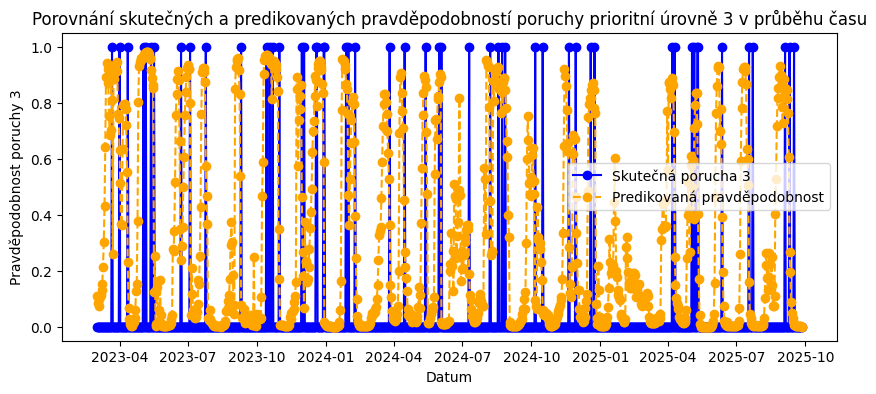

In [27]:
# Vykreslení skutečných a predikovaných pravděpodobností
plt.figure(figsize=(10, 4))
plt.plot(result2_df['Datum'], result2_df['Real_probabilities'], label='Skutečná porucha 3', color='blue', marker='o')
plt.plot(result2_df['Datum'], result2_df['Predicted_Probabilities'], label='Predikovaná pravděpodobnost', linestyle='dashed', color='orange', marker='o')
plt.title('Porovnání skutečných a predikovaných pravděpodobností poruchy prioritní úrovně 3 v průběhu času')
plt.xlabel('Datum')
plt.ylabel('Pravděpodobnost poruchy 3')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error

# Výpočet Mean Squared Error
mse = mean_squared_error(result2_df['Real_probabilities'], result2_df['Predicted_Probabilities'])
print(f"Mean Squared Error: {mse}")
# MSE měří průměrný kvadrát odchylek mezi skutečnými a předpovězenými hodnotami.
# Kvadrát zvyšuje váhu větších odchylek, což znamená, že MSE je citlivější na odlehlé hodnoty.
# Nižší hodnota MSE indikuje lepší přesnost.
# Předpokládejme, že MSE je 0.002. 
# To znamená, že průměrný kvadrát rozdílu mezi skutečnými a předpovězenými pravděpodobnostmi je 0.002. 
# Pokud byla skutečná pravděpodobnost 0.2, model by předpověděl hodnotu kolem 0.202.

Mean Squared Error: 0.22198982211403392


In [49]:
from sklearn.metrics import mean_absolute_error

# Výpočet Mean Absolute Error
mae = mean_absolute_error(result2_df['Real_probabilities'], result2_df['Predicted_Probabilities'])
print(f"Mean Absolute Error: {mae}")
# MAE měří průměrnou absolutní odchylku mezi skutečnými a předpovězenými hodnotami. 
# Jednotkou MAE je jednotka měření samotné veličiny, kterou předpovídáme. 
# Například, pokud předpovídám pravděpodobnost v % a mám MAE 0.2, znamená to, 
# že průměrná odchylka předpovědí od skutečnosti je 20%.

Mean Absolute Error: 0.31789623358837416


In [29]:
# Příprava prázdného seznamu pro ukládání predikovaných pravděpodobností
future_predictions = []

In [30]:
# Příprava vstupních dat pro predikci (posledních 60 dní, pokud jsou dostupné)
input_data = scaled_data[-interval:].reshape(1, -1, 3)

In [31]:
prediction_length=14

In [44]:
input_data

array([[[1.66666667e-01, 0.00000000e+00, 9.54954955e-01],
        [3.33333333e-01, 0.00000000e+00, 9.55955956e-01],
        [5.00000000e-01, 6.66666667e-01, 9.56956957e-01],
        [6.66666667e-01, 0.00000000e+00, 9.57957958e-01],
        [8.33333333e-01, 0.00000000e+00, 9.58958959e-01],
        [1.00000000e+00, 0.00000000e+00, 9.59959960e-01],
        [0.00000000e+00, 0.00000000e+00, 9.60960961e-01],
        [1.66666667e-01, 0.00000000e+00, 9.61961962e-01],
        [3.33333333e-01, 0.00000000e+00, 9.62962963e-01],
        [5.00000000e-01, 0.00000000e+00, 9.63963964e-01],
        [6.66666667e-01, 0.00000000e+00, 9.64964965e-01],
        [8.33333333e-01, 0.00000000e+00, 9.65965966e-01],
        [1.00000000e+00, 0.00000000e+00, 9.66966967e-01],
        [0.00000000e+00, 0.00000000e+00, 9.67967968e-01],
        [1.66666667e-01, 0.00000000e+00, 9.68968969e-01],
        [3.33333333e-01, 0.00000000e+00, 9.69969970e-01],
        [5.00000000e-01, 0.00000000e+00, 9.70970971e-01],
        [6.666

In [32]:
# Generování predikcí pro následujících 14 dní
for _ in range(prediction_length):
    # Predikce pravděpodobnosti na aktuální den
    prediction = model.predict(input_data)
    
    # Ukládání predikce do seznamu
    future_predictions.append(prediction[0, 0])
    
    # Aktualizace vstupních dat pro další predikci
    input_data = np.append(input_data[:, 1:, :], np.array([[[prediction[0, 0], 0, 0]]]), axis=1)

1/1 [==============================] - 0s 26ms/step


In [33]:
# Zkopírování result2_df do result3_df
result3_df = result2_df.copy()
result3_df.head()

,Datum,Den_v_tydnu,Porucha,Timestamp,Predicted_Probabilities,Real_probabilities
60,2023-03-02,3,0,1677715200000000000,0.108188,0
61,2023-03-03,4,0,1677801600000000000,0.085644,0
62,2023-03-04,5,0,1677888000000000000,0.075303,0
63,2023-03-05,6,0,1677974400000000000,0.099624,0
64,2023-03-06,0,0,1678060800000000000,0.105661,0


In [34]:
# Vytvoření indexu pro následujících 14 dní
future_index = pd.date_range(start=result2_df['Datum'].iloc[-1] + pd.Timedelta(days=1), periods=(prediction_length+1), freq='D')

In [35]:
# Příprava seznamu nových řádků pro budoucnost
new_rows = []

# Přidání 14 dalších řádků do result3_df pro budoucnost
for date, prediction in zip(future_index, future_predictions):
    # Přidání nového řádku s nulovou hodnotou poruchy (protože predikujeme budoucnost)
    new_rows.append({
        'Datum': date,
        'Den_v_tydnu': date.dayofweek,
        'Porucha': 0,
        'Timestamp': int(date.timestamp() * 1e9), 
        'Predicted_Probabilities': prediction,
        'Real_probabilities': 0  # Přidání sloupce Real_probabilities a nastavení na hodnotu 0
    })

In [36]:
# Připojení nových řádků k result3_df
result3_df = pd.concat([result2_df, pd.DataFrame(new_rows)], ignore_index=True)

In [37]:
# Zobrazení result3_df
result2_df.tail()

,Datum,Den_v_tydnu,Porucha,Timestamp,Predicted_Probabilities,Real_probabilities
995,2025-09-22,0,0,1758499200000000000,0.001899,0
996,2025-09-23,1,0,1758585600000000000,0.002658,0
997,2025-09-24,2,1,1758672000000000000,0.001934,0
998,2025-09-25,3,0,1758758400000000000,0.000956,0
999,2025-09-26,4,0,1758844800000000000,0.000769,0


In [38]:
# Zobrazení result3_df
result3_df.tail()

,Datum,Den_v_tydnu,Porucha,Timestamp,Predicted_Probabilities,Real_probabilities
949,2025-10-06,0,0,1759708800000000000,0.126583,0
950,2025-10-07,1,0,1759795200000000000,0.203689,0
951,2025-10-08,2,0,1759881600000000000,0.078775,0
952,2025-10-09,3,0,1759968000000000000,0.073363,0
953,2025-10-10,4,0,1760054400000000000,0.069222,0


In [45]:
# Získání posledních X hodnot
last_plot_values = result3_df.tail(400)

In [46]:
# Specifikace data pro vertikální čáru
separator_date = result2_df['Datum'].max()
print(separator_date)


2025-09-26 00:00:00


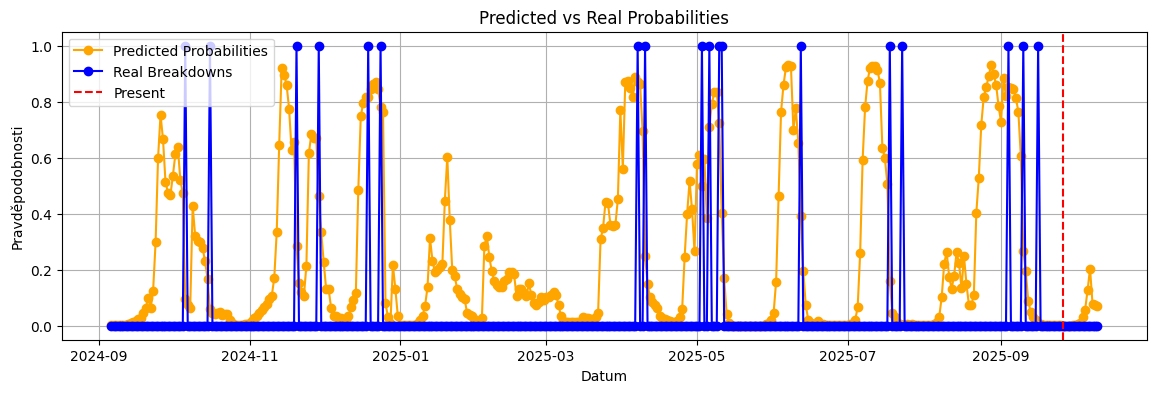

In [48]:
# Vykreslení grafu
plt.figure(figsize=(14, 4))

plt.plot(last_plot_values['Datum'], last_plot_values['Predicted_Probabilities'], label='Predicted Probabilities', color='orange', marker='o')
plt.plot(last_plot_values['Datum'], last_plot_values['Real_probabilities'], label='Real Breakdowns', color='blue', marker='o')

# Přidání červené svislé čáry
# plt.axvline(x=separator_position, color='red', linestyle='--', label='Separator Date')
plt.axvline(x=separator_date, color='red', linestyle='--', label='Present')


plt.title('Predicted vs Real Probabilities')
plt.xlabel('Datum')
plt.ylabel('Pravděpodobnosti')
plt.legend()
plt.grid(True)
plt.show()